In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

# User inputs

In [2]:
start_date = '20221130'
end_date = '20230509'

tidy_dataset_fn = f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_daily_dataset_output_fn = f"tidy_df_daily_{start_date}_{end_date}_noplanar_fit.parquet"

# Load data

In [3]:
try:
    tidy_df_5Min = pd.read_parquet(
        tidy_dataset_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

In [4]:
src = tidy_df_5Min.query("variable == 'T_3m_c'").set_index('time')[['value']]
src = src[src.value.isna()].reset_index()
src['diff'] = (src['time'] - src['time'].shift(1)).apply(lambda t_delta: t_delta.seconds)
src = src.reset_index(drop=True)
src

,time,value,diff
0,2023-01-22 23:42:30,NaN,NaN
1,2023-01-22 23:47:30,NaN,300.0
2,2023-01-22 23:52:30,NaN,300.0
3,2023-01-31 16:07:30,NaN,58500.0
4,2023-01-31 16:12:30,NaN,300.0
...,...,...,...
904,2023-04-23 22:07:30,NaN,300.0
905,2023-04-23 22:12:30,NaN,300.0
906,2023-05-05 15:32:30,NaN,62400.0
907,2023-05-05 15:37:30,NaN,300.0


In [5]:
data = tidy_df_5Min.query("variable == 'T_3m_c'").set_index('time')['value']
na_groups = data.notna().cumsum()[data.isna()]
t_lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)

data = tidy_df_5Min.query("variable == 'RH_3m_c'").set_index('time')['value']
na_groups = data.notna().cumsum()[data.isna()]
rh_lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)

# Examine pot. virtual temperature gradient

In [6]:
np.abs(tidy_df_5Min[tidy_df_5Min.measurement == 'temperature gradient'].value).min()

1.842531134776948e-07

In [7]:
alt.Chart(
    tidy_df_5Min.query("measurement == 'temperature gradient'").query("height < 5")
).mark_line().encode(
    x = 'time:T',
    y = 'value:Q',
    column='height:O'
).properties(width=200, height = 200) & alt.Chart(
    tidy_df_5Min.query("measurement == 'temperature gradient'").query("height < 5")
).mark_bar().encode(
    alt.X('value:Q').bin(step=0.1),
    alt.Y("count():Q"),    
    alt.Column('height:O')
).properties(width=200, height = 200)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [8]:
src = tidy_df_5Min.query("variable == 'temp_gradient_3m_c'")
neutral_times = src[src['value'].abs() < 0.01].time

In [9]:
alt.Chart(
    tidy_df_5Min[
        tidy_df_5Min.time.isin(neutral_times.sample(16))
    ].query("measurement == 'wind speed'").query("tower == 'c'")
).mark_line().encode(
    alt.X("value:Q").title("Wind speed (m/s)").sort('-y'),
    alt.Y("height:Q").title("Height (m)"),
    alt.Facet("time:O", columns=8)
).properties(width = 125, height = 125)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [10]:
z0_df = tidy_df_5Min[
    tidy_df_5Min.time.isin(neutral_times)
].query("tower == 'c'")
src_snowdepth = tidy_df_5Min[
    tidy_df_5Min.measurement == 'snow depth'
]
src_snowdepth = src_snowdepth[['time', 'value']].set_index('time').rename(columns={'value': 'snow_depth'})
z0_df = z0_df[z0_df.measurement.isin([
    'wind speed',
    'shear velocity',
    'snow depth'
])]
z0_df = z0_df[~z0_df.variable.str.contains("predicted")]
z0_df = z0_df.pivot_table(index=['time'], values='value', columns='variable')
z0_df = z0_df.join(src_snowdepth)
z0_df.head()

,spd_10m_c,spd_15m_c,spd_20m_c,spd_2m_c,spd_3m_c,spd_5m_c,u*_10m_c,u*_15m_c,u*_20m_c,u*_2m_c,u*_3m_c,u*_5m_c,snow_depth
time,,,,,,,,,,,,,
2022-11-30 10:37:30,0.261196,0.261303,0.278766,0.294917,0.288938,0.263247,0.092021,0.060278,0.119137,0.082064,0.098465,0.075811,0.261997
2022-11-30 12:37:30,0.375744,0.368134,0.320001,0.332643,0.329449,0.390361,0.050571,0.051124,0.071796,0.055077,0.076588,0.070909,0.261997
2022-11-30 12:47:30,0.675300,0.651386,0.612457,0.723600,0.763967,0.736115,0.120388,0.123114,0.136278,0.076045,0.049296,0.053659,0.261997
2022-11-30 13:02:30,1.602720,1.645096,1.631929,1.397709,1.489085,1.518906,0.152537,0.113622,0.082739,0.109909,0.111435,0.142778,0.261997
2022-11-30 13:07:30,0.848206,0.888767,0.873107,0.787879,0.850785,0.839572,0.101733,0.115202,0.119509,0.061890,0.085271,0.121159,0.261997


# Filter out data without monotonically increasing wind speeds 

In [11]:
len(z0_df)

4220

In [12]:
def monotonically_increasing(l):
    return all(x < y for x, y in zip(l, l[1:]))

z0_df['is_monotonic_increasing'] = z0_df.apply(
    lambda row: monotonically_increasing([
            row['spd_2m_c'], 
            row['spd_3m_c'], 
            row['spd_5m_c'], 
            row['spd_10m_c'], 
            row['spd_15m_c'], 
            row['spd_20m_c']
    ]),
    axis = 1
)

In [13]:
z0_df = z0_df[z0_df.is_monotonic_increasing]

In [14]:
len(z0_df)

1960

# Solve for $z_0$ assuming $d = 0$

https://www.eol.ucar.edu/content/calculation-roughness-length-and-displacement-height

In [15]:
von_karman = 0.4

In [16]:
d = 0.0
z0_df['z0_2m_c'] = (2 - d - z0_df['snow_depth'])/np.exp(z0_df['spd_2m_c']*von_karman/z0_df['u*_2m_c'])
z0_df['z0_3m_c'] = (3 - d - z0_df['snow_depth'])/np.exp(z0_df['spd_3m_c']*von_karman/z0_df['u*_3m_c'])
z0_df['z0_5m_c'] = (5 - d - z0_df['snow_depth'])/np.exp(z0_df['spd_5m_c']*von_karman/z0_df['u*_5m_c'])
z0_df['z0_10m_c'] = (10 - d - z0_df['snow_depth'])/np.exp(z0_df['spd_10m_c']*von_karman/z0_df['u*_10m_c'])
z0_df['z0_15m_c'] = (15 - d - z0_df['snow_depth'])/np.exp(z0_df['spd_15m_c']*von_karman/z0_df['u*_15m_c'])
z0_df['z0_20m_c'] = (20 - d - z0_df['snow_depth'])/np.exp(z0_df['spd_20m_c']*von_karman/z0_df['u*_20m_c'])

In [17]:
variables = [
        'z0_2m_c', 
        'z0_3m_c', 
        'z0_5m_c', 
        'z0_10m_c', 
        'z0_15m_c', 
        'z0_20m_c', 
    ]
alt.Chart(
    z0_df[variables].reset_index()
).transform_fold(
    variables
).transform_filter(
    alt.FieldOneOfPredicate('key', ['z0_2m_c', 'z0_3m_c'])
).mark_circle().encode(
    alt.X('time:T'),
    alt.Y("value:Q").scale(type='log'),
    alt.Row("key:N", sort=variables)
).properties(height = 100, width = 400)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [18]:
from sklearn.metrics import r2_score

In [19]:
alt.Chart(z0_df).mark_circle().encode(
    alt.X("z0_3m_c").scale(domain=[0.000000001, 10], type='log'),
    alt.Y("z0_2m_c").scale(domain=[0.000000001, 10], type='log')
).properties(width = 150, height = 150, title = str(round(r2_score(
        z0_df["z0_3m_c"],
        z0_df["z0_2m_c"]
    ), 3))
) | alt.Chart(z0_df).mark_circle().encode(
    alt.X("z0_3m_c").scale(domain=[0.000000001, 10], type='log'),
    alt.Y("z0_5m_c").scale(domain=[0.000000001, 10], type='log')
).properties(width = 150, height = 150, title = str(round(r2_score(
        z0_df["z0_3m_c"],
        z0_df["z0_5m_c"]
    ), 3))
) | alt.Chart(z0_df).mark_circle().encode(
    alt.X("z0_3m_c").scale(domain=[0.000000001, 10], type='log'),
    alt.Y("z0_10m_c").scale(domain=[0.000000001, 10], type='log')
).properties(width = 150, height = 150, title = str(round(r2_score(
        z0_df["z0_3m_c"],
        z0_df["z0_10m_c"]
    ), 3))
) | alt.Chart(z0_df).mark_circle().encode(
    alt.X("z0_3m_c").scale(domain=[0.000000001, 10], type='log'),
    alt.Y("z0_15m_c").scale(domain=[0.000000001, 10], type='log')
).properties(width = 150, height = 150, title = str(round(r2_score(
        z0_df["z0_3m_c"],
        z0_df["z0_15m_c"]
    ), 3))
) | alt.Chart(z0_df).mark_circle().encode(
    alt.X("z0_3m_c").scale(domain=[0.000000001, 10], type='log'),
    alt.Y("z0_20m_c").scale(domain=[0.000000001, 10], type='log')
).properties(width = 150, height = 150, title = str(round(r2_score(
        z0_df["z0_3m_c"],
        z0_df["z0_20m_c"]
    ), 3))
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [20]:
alt.Chart(
    z0_df[['z0_3m_c']].resample("1D").median().reset_index()
).mark_circle(size=50).encode(
    alt.X("time:T"),
    alt.Y("z0_3m_c").scale(type='log')
) + alt.Chart(
    z0_df[['z0_3m_c']].resample("1D").median().reset_index()
).mark_bar(width=1).encode(
    alt.X("time:T"),
    alt.Y("z0_3m_c").scale(type='log')
).properties(height = 100)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [21]:
z0_df_weekly = z0_df[['z0_3m_c']].resample("W-MON").median().reset_index()

In [22]:
basic_z0_values_chart = alt.Chart(
    z0_df_weekly
).mark_circle(size=100).encode(
    alt.X("time:T"),
    alt.Y("z0_3m_c").scale(type='log')
) + alt.Chart(
    z0_df_weekly
).mark_bar(width=1).encode(
    alt.X("time:T"),
    alt.Y("z0_3m_c").scale(type='log')
).properties(height = 100)
basic_z0_values_chart

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Use Andreas et al. 2010 Method, NOAA/SPLASH (Chris Cox) solution

In [25]:
tdk = 273.15 
# surface temp mean
Tsm = tidy_df_5Min.query("variable == 'Tsurf_c'")['value'].values 
# air temp mean
Tam = tidy_df_5Min.query("variable == 'T_3m_c'")['value'].values 
# height of sonic
z_level_n = 3 - tidy_df_5Min.query("variable == 'SnowDepth_d'")['value'].values 
# wt-covariance, vertical flux of the sonic temperature  [deg m/s]
wT_csp = tidy_df_5Min.query("variable == 'w_tc__3m_c'")['value'].values   
wq_csp = tidy_df_5Min.query("variable == 'w_h2o__3m_c'")['value'].values   
wsp = tidy_df_5Min.query("variable == 'spd_3m_c'")['value'].values 
ustar = tidy_df_5Min.query("variable == 'u*_3m_c'")['value'].values 

surface_pot_temp = tidy_df_5Min.query("variable == 'Tsurfpot_c'")['value'].values
air_pot_temp  = tidy_df_5Min.query("variable == 'Tpot_3m_c'")['value'].values
surface_mixing_ratio = tidy_df_5Min.query("variable == 'Tsurfmixingratio_c'")['value'].values
air_mixing_ratio = tidy_df_5Min.query("variable == 'mixingratio_3m_c'")['value'].values
surface_specifichumidity = surface_mixing_ratio / (1 + surface_mixing_ratio)
air_specifichumidity  = air_mixing_ratio / (1 + air_mixing_ratio)

# Obukhov length
surflayr_avg_airtemp = 0.5*(Tsm + Tam)
surflayr_avg_specifichumidity = 0.5*(surface_specifichumidity + air_specifichumidity)
surflayr_avg_virtualtemp = 0.5*(
    tidy_df_5Min.query("variable == 'Tvirtual_3m_c'")['value'].values + 
    tidy_df_5Min.query("variable == 'Tsurfvirtual_c'")['value'].values
)
# right version of equation 2.3 in Andreas 2010
# L = - (
#     surflayr_avg_airtemp/( 0.4*9.81 )
# ) * (
#     ustar**3 / (
#         wT_csp + wq_csp* (0.61*surflayr_avg_airtemp)/(
#             1 + 0.61*surflayr_avg_specifichumidity
#           )
#     )
# )
# left version of equation 2.3 in Andreas 2010
L = - (
    (
        tidy_df_5Min.query("variable == 'Tvirtual_3m_c'")['value'].values
    )/( 0.4*9.81 )
) * (
    ustar**3 / wT_csp
)

# Monin-Obukhov stability parameter, z/L:
zeta_level_n = z_level_n/L

# Drag coefficient, Cd:
Cd = ustar**2/wsp**2 #- wu_csp/(wsp**2)

Ch = wT_csp / (wsp * (surface_pot_temp - air_pot_temp))

Ce = wq_csp / (wsp * (surface_specifichumidity - air_specifichumidity))

In [27]:
import sys
sys.path.append("../splash/")
import calc_z0
z0_values = calc_z0.calc_z0(z_level_n, Cd, zeta_level_n)
z0T_values = calc_z0.calc_z0T(z_level_n, Cd, Ch, zeta_level_n)
z0q_values = calc_z0.calc_z0Q(z_level_n, Cd, Ce, zeta_level_n)

/home/elilouis/sublimationofsnow/analysis/paper1/../splash/calc_z0.py:16: RuntimeWarning: invalid value encountered in power
  sma = 1 + (6.5 * zL * (1+zL)**(1/3)) / (1.3 + zL); # Psi
/home/elilouis/sublimationofsnow/analysis/paper1/../splash/calc_z0.py:20: RuntimeWarning: invalid value encountered in power
  x = np.real((1 - 16*zL)**(0.25)) # assumes gamma = 16
/home/elilouis/sublimationofsnow/analysis/paper1/../splash/calc_z0.py:36: RuntimeWarning: invalid value encountered in power
  sma = 1 + (6.5 * zL * (1+zL)**(1/3)) / (1.3 + zL); # Psi
/home/elilouis/sublimationofsnow/analysis/paper1/../splash/calc_z0.py:37: RuntimeWarning: invalid value encountered in power
  x = np.real((1 - 16*zL)**(0.25)) # assumes gamma = 16
/home/elilouis/sublimationofsnow/analysis/paper1/../splash/calc_z0.py:44: RuntimeWarning: overflow encountered in exp
  z0 = z * np.exp(-(k*(Cd**0.5)*(Ch**-1) + sm))
/home/elilouis/sublimationofsnow/analysis/paper1/../splash/calc_z0.py:44: RuntimeWarning: overflow encou

In [28]:
time_values = tidy_df_5Min.query("variable == 'Tsurf_c'").set_index('time').sort_index().index.values

In [29]:
z0_andreas_df = pd.DataFrame({
    "time": time_values, 
    "z0":   z0_values,
    "z0T": z0T_values,
    "z0q": z0q_values,
})
z0_andreas_df_weekly = z0_andreas_df.set_index('time').resample('W-MON').median().reset_index()

In [31]:
z0_andreas_df.head(3)

,time,z0,z0T,z0q
0,2022-11-29 17:02:30,0.076182,2050.978978,1.972075
1,2022-11-29 17:07:30,0.019717,94.869536,1.326326
2,2022-11-29 17:12:30,0.006696,12.654200,0.797514


In [32]:
len(z0_andreas_df), len(z0_andreas_df[ z0_andreas_df['z0'] > 1e-8]), len(z0_andreas_df[ (z0_andreas_df['z0'] > 1e-8) & (z0_andreas_df['z0'] < 0.1)])

(46368, 38413, 36563)

In [33]:
alt.Chart(
    z0_andreas_df
).mark_circle().encode(
    alt.X('time:T'),
    alt.Y("z0:Q").scale(type='log'),
).properties(height = 100, width = 400)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [34]:
alt.Chart(
    z0_andreas_df[ 
        (z0_andreas_df['z0'] > 1e-8) & (z0_andreas_df['z0'] < 0.1)
    ].set_index('time').groupby(
        pd.Grouper(freq='60Min')
    ).median().reset_index()
).mark_circle().encode(
    alt.X('time:T'),
    alt.Y("z0:Q").scale(type='log'),
).properties(height = 100, width = 400)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [35]:
z0_andreas_df.set_index('time').median()

z0     1.591028e-04
z0T    3.999040e-07
z0q    1.819003e-01
dtype: float64

In [61]:
z0_andreas_df.set_index('time').median()

z0     2.041763e-04
z0T    7.079812e-07
z0q    2.247612e-01
dtype: float64

In [62]:
z0_andreas_df.set_index('time').mean()

z0     1.576713e-02
z0T             inf
z0q    3.010954e+44
dtype: float64

In [63]:
complex_z0_values_chart = alt.Chart(
    z0_andreas_df_weekly
).mark_circle(size=100, color='red', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("z0").scale(type='log')
) + alt.Chart(
    z0_andreas_df_weekly
).mark_bar(width=1).encode(
    alt.X("time:T"),
    alt.Y("z0").scale(type='log')
).properties(height = 100)

In [66]:
(   
    basic_z0_values_chart.properties(title='Basic method') 
    | 
    complex_z0_values_chart.properties(title='Complex method')   
).resolve_scale(y='shared')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [67]:
alt.Chart(
    z0_andreas_df_weekly
).mark_circle(size=100, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("z0").scale(type='log')
) + alt.Chart(
    z0_andreas_df_weekly
).mark_circle(size=100, color='red', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("z0T").scale(type='log')
) + alt.Chart(
    z0_andreas_df_weekly
).mark_circle(size=100, color='blue', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("z0q").scale(type='log')
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [68]:
(   
    basic_z0_values_chart.properties(title='Basic method') 
    + 
    complex_z0_values_chart.properties(title='Complex method')   
).resolve_scale(y='shared')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [70]:
(   
    basic_z0_values_chart.properties(title='Basic method') 
    + 
    complex_z0_values_chart.properties(title='Complex method')   
).resolve_scale(y='shared')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [71]:
src = pd.merge(
    z0_df_weekly.rename(columns={'z0_3m_c': 'z0 (simple)'}),
    z0_andreas_df_weekly.rename(columns={'z0': 'z0 (Andreas)'}),
    on='time'
)
alt.Chart(
    src
).mark_circle().encode(
    alt.X("z0 (simple):Q").scale(type='log'),
    alt.Y("z0 (Andreas):Q").scale(type='log'),
    # tooltip = 'time:T'
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Decent agreement between weekly z0 values calculated with the two methods, but don't line up too well

In [72]:
from sklearn.metrics import r2_score

In [73]:
src = pd.merge(
    z0_df.rename(columns={'z0_3m_c': 'z0 (simple)'}),
    z0_andreas_df.rename(columns={'z0': 'z0 (Andreas)'}),
    on='time'
)
alt.Chart(
    src
).mark_circle().encode(
    alt.X("z0 (simple):Q").scale(type='log'),
    alt.Y("z0 (Andreas):Q").scale(type='log'),
    # tooltip = 'time:T'
).properties(
    width = 200, 
    height=200, 
    title=f"r2 = {
        round(r2_score(src["z0 (simple)"], src["z0 (Andreas)"]), 4)
    }"
)



<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [74]:
src['day'] = src.time.dt.date
alt.Chart(
    src
).mark_circle().encode(
    alt.X("z0 (simple):Q").scale(type='linear'),
    alt.Y("z0 (Andreas):Q").scale(type='linear'),
    tooltip = 'day:T'
).properties(
    width = 200, 
    height=200, 
    title=f"r2 = {
        round(r2_score(src["z0 (simple)"], src["z0 (Andreas)"]), 4)
    }"
)



<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [75]:
src['diff'] = src['z0 (simple)'] = src["z0 (Andreas)"]

In [76]:

alt.Chart(
    src
).transform_fold(
    ["z0 (simple)",     "z0 (Andreas)"]
).mark_circle().encode(
    alt.X("time:T"),
    alt.Y("value:Q").scale(type='log'),
    alt.Color("key:N")
).properties(width = 1200)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Fantastic agreement between the 5-minute calculated z0 values. Note that the "simple" method has far fewer data points available

In [78]:


alt.Chart(
    z0_andreas_df.set_index('time').resample("1D").median().reset_index()
).mark_circle(size=50).encode(
    alt.X("time:T"),
    alt.Y("z0").scale(type='log')
).properties(height = 100).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [79]:
logbins = []
for power in [-7, -6, -5, -4, -3, -2, -1]:
    logbins.append(1*10**power)
    # logbins.append(5*10**power)
logbins

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]

Text(0.5, 1.0, 'Using bins [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]')

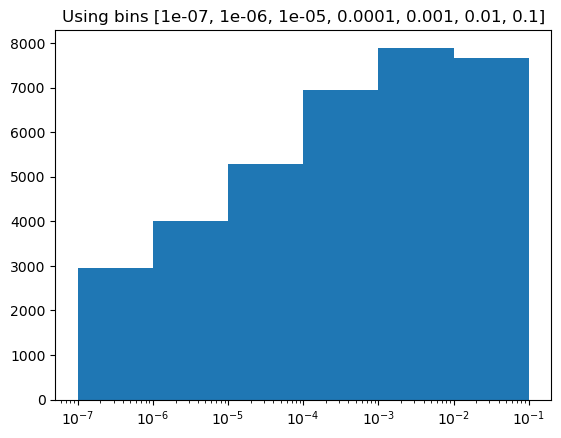

In [80]:
plt.hist(
    z0_andreas_df['z0'],
    bins=logbins
)
plt.xscale('log')
plt.title(f"Using bins {logbins}")

In [82]:
src = tidy_df_5Min.query("variable == 'L_3m_c'").set_index('time').rename(
    columns = {'value': 'L_3m_c'}
)[['L_3m_c']].join(
    tidy_df_5Min.query("variable == 'u*_3m_c'").set_index('time').rename(
        columns = {'value': 'ustar_3m_c'}
    )[['ustar_3m_c']]
).join(
    z0_andreas_df.set_index('time')
)
# positive - stable
# negative - unstable
src['stability'] = src['L_3m_c'].apply(lambda L: 'stable' if L > 0 else 'unstable')
src.head()

,L_3m_c,ustar_3m_c,z0,z0T,z0q,stability
time,,,,,,
2022-11-29 17:02:30,-16.815512,0.377098,0.075744,2039.184068,1.960734,unstable
2022-11-29 17:07:30,-4.879467,0.249449,0.019548,94.059692,1.315004,unstable
2022-11-29 17:12:30,-2.556141,0.265064,0.006610,12.491891,0.787284,unstable
2022-11-29 17:17:30,-2.655310,0.301103,0.005612,2.399159,0.933654,unstable
2022-11-29 17:22:30,-2.447218,0.375441,0.015312,0.966156,0.830087,unstable


In [83]:
(
# Chart 1
alt.Chart(
    src.query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
).mark_circle(
    size=3,
    opacity=0.25
).encode(
    alt.X("ustar_3m_c").title("u* at 3 meters on tower c"),
    alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
) +
# Chart 2
alt.Chart(
    src.query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
).mark_boxplot(
    opacity=0.5,
    color='black', 
    extent='min-max'
).encode(
    alt.X("ustar_3m_c").title("u* at 3 meters on tower c").bin(maxbins=35),
    alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
)
).configure_axis(grid=False)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [85]:
alt.layer(
    alt.Chart().mark_circle(
        size=3,
        opacity=0.25
    ).encode(
        alt.X("ustar_3m_c").title("u* at 3 meters on tower c"),
        alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
    ) +
    # Chart 2
    alt.Chart().mark_boxplot(
        opacity=0.5,
        color='black', 
        extent='min-max'
    ).encode(
        alt.X("ustar_3m_c").title("u* at 3 meters on tower c").bin(maxbins=35),
        alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
    ),
    data = src.query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
).facet("stability")

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [86]:
(
# Chart 1
alt.Chart(
    src.query("stability == 'unstable'").query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
).mark_circle(
    size=3,
    opacity=0.25
).encode(
    alt.X("ustar_3m_c").title("u* at 3 meters on tower c"),
    alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
) +
# Chart 2
alt.Chart(
    src.query("stability == 'unstable'").query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
).mark_boxplot(
    opacity=0.5,
    color='black', 
    extent='min-max'
).encode(
    alt.X("ustar_3m_c").title("u* at 3 meters on tower c").bin(maxbins=35),
    alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
)
).configure_axis(grid=False)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [87]:
src['ustar_3m_c bin'] = pd.cut(src['ustar_3m_c'], np.arange(0.0, 0.7, 0.02))
src['ustar_3m_c bin'] = src['ustar_3m_c bin'].apply(lambda x: x.left+0.01)
import scipy.stats as stats
gmeans = pd.DataFrame(src.groupby('ustar_3m_c bin')['z0'].apply(lambda x: stats.gmean(x))).reset_index()

gmeans_stable = pd.DataFrame(src.query("L_3m_c > 0").groupby('ustar_3m_c bin')['z0'].apply(lambda x: stats.gmean(x))).reset_index()
gmeans_unstable = pd.DataFrame(src.query("L_3m_c < 0").groupby('ustar_3m_c bin')['z0'].apply(lambda x: stats.gmean(x))).reset_index()

/tmp/ipykernel_17575/620765223.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gmeans = pd.DataFrame(src.groupby('ustar_3m_c bin')['z0'].apply(lambda x: stats.gmean(x))).reset_index()
/tmp/ipykernel_17575/620765223.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gmeans_stable = pd.DataFrame(src.query("L_3m_c > 0").groupby('ustar_3m_c bin')['z0'].apply(lambda x: stats.gmean(x))).reset_index()
/tmp/ipykernel_17575/620765223.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed

In [88]:
(
    (
        alt.Chart(
            src.query("L_3m_c > 0").query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
        ).mark_circle(
            size=3,
            opacity=0.25
        ).encode(
            alt.X("ustar_3m_c").title("u* at 3 meters on tower c"),
            alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
        ) +\
        alt.Chart(gmeans_stable).mark_circle().encode(
            alt.X("ustar_3m_c bin:Q"),
            alt.Y("z0").scale(type='log')
        )
    ).properties(title='Stable') | (
        alt.Chart(
            src.query("L_3m_c < 0").query("ustar_3m_c < 0.7").query("z0 > 0.00000001")
        ).mark_circle(
            size=3,
            opacity=0.25
        ).encode(
            alt.X("ustar_3m_c").title("u* at 3 meters on tower c"),
            alt.Y("z0").title("Measured z_0 (m)").scale(type='log')
        ) +\
        alt.Chart(gmeans_unstable).mark_circle().encode(
            alt.X("ustar_3m_c bin:Q"),
            alt.Y("z0").scale(type='log')
        )
    ).properties(title="Unstable")
).resolve_scale(y='shared', x='shared')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Save roughness length values

In [ ]:
z0_andreas_df.to_parquet("z0estimates/z0_andreas_df.parquet")
z0_andreas_df_weekly.to_parquet("z0estimates/z0_andreas_df_weekly.parquet")
z0_df.to_parquet("z0estimates/z0_df.parquet")
z0_df_weekly.to_parquet("z0estimates/z0_df_weekly.parquet")